# 2.08 Ending
A spesific chord pattern can be added at the end of the "song"

In [335]:
from pyknon.genmidi import Midi
from pyknon.music import Rest, Note, NoteSeq
import numpy as np
import matplotlib.pyplot as plt

__Instruments:__
Available are at lest the 128 General-Midi (GM) Instruments. Depending on the sound-fonts there is a bigger choise. A list of the GM instruments can be found here. https://jazz-soft.net/demo/GeneralMidi.html


In [336]:
major = np.array([ 0, 2, 4, 5, 7, 9, 11])
minor = np.array([ 0, 2, 3, 5, 7, 8, 10])  
blues = np.array([ 0, 3, 5, 6, 7, 10])
C7 = np.array([ 0, 4, 7, 10]) 
CM7 = np.array([ 0, 4, 7, 11])
Cm7 = np.array([ 0, 3, 7, 10])
Cm  = np.array([ 0, 3, 7])
C   = np.array([ 0, 4, 7])
power = np.array([ 0,7])
bass= np.array([ 0])

In [337]:

def scale_create(tones):
    tones = np.asarray(tones)   # tones which form chord or scale in the first octave (0-11)
    if any(tones > 11):             # tones over one octave?
        tones = np.mod(tones,12)    # set the thones in one octave
        tones = np.sort(tones)      # sort the tones new
        tones = np.unique(tones)    # remove duplicate tones
    octave = np.repeat( np.linspace(0,108, num=10), len(tones))
    scale = np.add( octave, np.tile(tones, 10)) # add element wise octave and note
    return scale.astype(int)
    
def fade(start,end,steps): # currently not in use
    fade = np.around( np.linspace(start,end,num=steps))
    fade = fade.astype(int)
    return fade

def ran_volume(volume, prob_volume, melody_len):
    volume = np.asarray(volume, dtype=int)         # this are the allowed volumes of thenotes
    prob_volume = np.asarray(prob_volume)          # this are the probabilities how often each volume will occure
    prob_volume = prob_volume/np.sum(prob_volume) 
    volumes = np.r_[np.random.choice(volume, size=melody_len, p=prob_volume)]
    return volumes

#   currently not in use
def intvl_melody(intvl, prob_intvl, melody_len):  #Interval Melody   
    intvl = np.asarray(intvl)            # Possible interval
    prob_intvl = np.asarray(prob_intvl)         # Probability of each interval
    prob_intvl = prob_intvl/np.sum(prob_intvl)
    intervals = np.r_[np.random.choice(intvl, size=melody_len, p=prob_intvl)] 
    imelody = np.cumsum(intervals)
    return imelody


#   liniar_range: Generates an range in which the instrument can play. 
def liniar_range(r_start, r_top, r_edge, r_end): # acceptance range of the instrument 
    h = 100 # hight of acceptance function
    a_range = np.zeros(121, dtype=int)  # only to midi =120 as 127 is not a complete octave
    np.put(a_range, range(r_start,r_top),  np.linspace(0,h, num=(r_top -r_start)) )
    np.put(a_range, range(r_top, r_edge),  np.linspace(h,h, num=(r_edge-r_top  )) )
    np.put(a_range, range(r_edge, r_end),  np.linspace(h,0, num=(r_end -r_edge )) )

    return a_range
    
#   i_last_note: finds de i value of the last not in the actual scale.
def i_last_note(note, scale):
    i_note = (np.abs(scale - note)).argmin()
    return i_note

#   intvl_next is a modification of intvl_melody. But it does only creats one interval and not an array/melody in one time.
def intvl_next(intvl, prob_intvl):  #singel interval
    intvl = np.asarray(intvl)            # Possible interval
    prob_intvl = np.asarray(prob_intvl)         # Probability of each interval
    prob_intvl = prob_intvl/np.sum(prob_intvl)
    interval = np.random.choice(intvl, size=1, p=prob_intvl)
    return interval[0]

#   acceptance: accepts and refuses proposed nots with Metropolis-Hasting Algorythem.
#     x is the value in the aceptance range of the current note, while x_new is it from the proposoal note
def acceptance(x, x_new):
    if x_new < 1:
        if x < 1:
            print('start_note not in range')
            return 
    quot = x_new/x
    if quot >= 1: return True
    if np.random.uniform(0,1)< quot: return True
    else: return False
    
#   ran_duration crats a random rythem with length melody_len (numbers of beats)
def ran_duration(duration, prob_duration, melody_len):    
    duration= np.asarray(duration)                  # this are the allowed durations of the notes
    prob_duration = np.asarray(prob_duration)       # this are the probabilities how often each will occure
    prob_duration = prob_duration/np.sum(prob_duration)
    cumsum, melody_len, rythem = 0, melody_len/4 , np.asarray([])  #melody_len/4 as note values are quarter
    while cumsum < melody_len:
        note_len = np.random.choice(duration, p=prob_duration)
        cumsum = cumsum + note_len
        rythem = np.append(rythem,note_len)
    return rythem , len(rythem)

#   plot_range: plot all ranges together
def plot_range(ranges,labels,title):
    fig, ax = plt.subplots()
    plt.xlabel('Midi Note')
    plt.ylabel('Acceptance')
    plt.title(title)

    for a_range, lab in zip(ranges,labels):
        ax.plot(range(121), a_range,label= lab )
    ax.vlines(x=np.linspace(0,108, num=10), ymin=0, ymax=10, color='grey', label='Octaves',linewidth=1) # plot octaves
    plt.legend()
    plt.show()
    
def acceptance_melody(intvl, prob_intvl, pattern, start_note, a_range, notenr, rythem):
    melody = np.zeros(notenr, dtype=int)
    cum_rythem = np.cumsum(rythem) *4
    cum_rythem = np.concatenate(([0],cum_rythem))[:-1] # add 0 at beginig remove last element
    scale_change = pattern[:,0]
    scale_nr =0
    scale = pattern[scale_nr,1]
    melody[0] = scale[i_last_note(start_note,scale)]
    
    for npn in range(1, notenr):  #npn: note per note (index)      
        scale_nr = np.ravel(np.argwhere(scale_change <= cum_rythem[npn-1])) [-1]     
        scale = pattern[scale_nr,1]

        accept = False    
        while not accept:       # aslong acept == False
            inote = i_last_note(melody[npn-1],scale)
            inote_next = inote + intvl_next(intvl, prob_intvl)         # add current not with Proposition
            accept_val = a_range[[melody[(npn-1)],scale[inote_next]]]  # get acceptance values
            accept = acceptance(accept_val[0],accept_val[1])
        melody[npn] = scale[inote_next]
    return melody


__pattern_gen__ The end pattern replaces the normal pattern at the end.

In [338]:
def pattern_gen(scales,end_scale, melody_len):
    bpb = 4  # beats per bar
    
#--scales
    scales   = np.asarray(scales)
    factor = int(np.trunc(melody_len/(np.sum(scales[:,0]) * bpb)) + 1) # factor rounded up: how many times is the pattern used
    change_times = np.cumsum(np.tile(scales[:,0],factor)) * bpb        # create change time list with factor
    change_times = np.concatenate((np.asarray([0]),change_times))[:-1] # add 0 at beginig remove last element
    
    for i in range(len(scales)):          # send scales to scale_create
        scales[i,1] = scale_create(scales[i,1])
    pattern = np.tile(scales,(factor,1))   # tile the scales as long the melody is
    pattern[:,0] = change_times            #insert change_times into scales
    
#--end_scales
    end_scale= np.asarray(end_scale)
    end_times = melody_len - np.cumsum(( end_scale[:,0]*bpb )[::-1])[::-1]   # reversed cumsum subtracted of melody_len
    end_scale[:,0] = end_times              #insert end_times into en_scale
    for i in range(len(end_scale)):         # send end_scale to scale_create
        end_scale[i,1] = scale_create(end_scale[i,1])

#--merge
    pattern = np.delete(pattern, np.argwhere(pattern[:,0] >= end_scale[0,0]) ,0) # remove unneeded scales
    pattern = np.concatenate((pattern,end_scale),axis=0)
    pattern = np.delete(pattern, np.argwhere(pattern[:,0] >= melody_len) ,0)     # remove if end is 0 bars
    return pattern

__tune_V:__ 
* A Ending Chord change is defined. It replaces the normal pattern at the end.
* the first voice has a diffrent pattern. It palys on the Blues scale.
* Three Piano voices play in a range of an octave and generete together the chords of the extended Blues scheme


In [444]:
def tune_V():
    tune_name = 'tune_V'  
    np.random.seed(120)
    bar, bpb = 12, 4  # bar: Takt , bpb: beat per bar
    melody_len = bar * bpb

    #scales = [[1,CM7],[1,Cm7+9],[1,Cm7+2],[1,C7+7]] #rythem Change
    #scales = [[4,C7],[2,C7+5],[2,C7],[1,C7+7],[1,C7+5],[2,C7]] # Blues 
    scales = [[1,C7],[1,C7+5],[2,C7],[2,C7+5],[2,C7],[1,C7+7],[1,C7+5],[1,C7],[1,C7+7]] # Blues erweitert
    end_scale = [[1,power]]
    pattern = pattern_gen(scales, end_scale, melody_len)
    pattern2 = pattern_gen([[12,blues]], end_scale, melody_len)
    
    # Solo voice
    range_1 = liniar_range(44,51,72,78)
    rythem1, notenr_1 = ran_duration([1/16,1/8, 1/4,1/2], [3,5,3,0.5], melody_len)
    melody1 = acceptance_melody([-2,-1, 0, 1, 2],[2, 3, 1, 3, 2],pattern2, 68, range_1, notenr_1, rythem1)
    volumes1 = ran_volume([0,127], [1,4], notenr_1 )
    notes1 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody1,rythem1,volumes1)] )
    
    # Bass voice
    range_2 = liniar_range(38,41,52,67)
    rythem2, notenr_2 = ran_duration([1/8, 1/4,1/2], [4,4,1], melody_len)
    melody2 = acceptance_melody([-2,-1, 0, 1, 2],[0, 3, 1, 3, 0],pattern, 46, range_2, notenr_2,rythem2)
    volumes2 = ran_volume([0,120], [0,8], notenr_2 )
    notes2 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody2,rythem2,volumes2)] )
    
    # Chord Voices
    range_3 = liniar_range(40,48,60,67)
    rythem3, notenr_3 = ran_duration([1/8, 1/4,1/2], [1,2,1], melody_len)
    melody3 = acceptance_melody([-2,-1, 0, 1, 2],[0, 3, 1, 3, 0],pattern, 48, range_3, notenr_3,rythem3)
    volumes3 = ran_volume([0,80], [0,8], notenr_3 )
    notes3 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody3,rythem3,volumes3)] )
    
    range_4 = liniar_range(40,48,60,67)
    rythem4, notenr_4 = ran_duration([1/8, 1/4,1/2], [1,2,1], melody_len)
    melody4 = acceptance_melody([-2,-1, 0, 1, 2],[0, 3, 1, 3, 0],pattern, 60, range_4, notenr_4,rythem4)
    volumes4 = ran_volume([0,80], [0,8], notenr_4 )
    notes4 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody4,rythem4,volumes4)] )
    
    range_5 = liniar_range(40,48,60,67)
    rythem5, notenr_5 = ran_duration([1/8, 1/4,1/2], [1,2,1], melody_len)
    melody5 = acceptance_melody([-2,-1, 0, 1, 2],[0, 3, 1, 3, 0],pattern, 54, range_5, notenr_5,rythem5)
    volumes5 = ran_volume([0,80], [0,8], notenr_5 )
    notes5= NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody5,rythem5,volumes5)] )
    
    
    plot_range([range_1,range_2,range_3],['range_1','range_2','range_3'],tune_name)
    instruments = [71,32,1,1,1]
    notes = [notes1,notes2,notes3,notes4,notes5]
    return notes, instruments,tune_name


In [445]:

def gen_midi():
#     squezze into a MIDI framework
    notes, instruments, tune_name = tune_V() #  <--- select a tune  <<--     <<<<<<<<<--- select a tune -----
    nTracks = len(notes)
    
    m = Midi(number_tracks=nTracks, tempo=120, instrument=instruments)
    for iTrack in range(nTracks):
        m.seq_notes(notes[iTrack], track=iTrack)

    #--- write the MIDI file -----
    midi_file_name = tune_name +'.mid'   # set the name of the file
    m.write(midi_file_name)
    return midi_file_name

## Midi: Play and Generate audio-file 
Externel players offered a better sound quality in comparison with python liaberys. We use __VLC__  and __Musescore__. The __soundfont__ for the VLC player is defined over the command line. For Musescore through the Gui in the preferences.


In [446]:
import subprocess
default_soundfont = '/usr/share/sounds/sf3/MuseScore_General.sf3'

def midi_play(midi_in, soundfont= default_soundfont):
    subprocess.call(['cvlc', midi_in , 'vlc://quit', '--soundfont', '/home/viturin/-vitis/Documents/MuseScore2/Soundfonts/Compifont_13082016.sf2'])   # cvlc = vlc without gui
    
def midi_audio(midi_in, name_out = 'none', soundfont= default_soundfont):
    if name_out == 'none' :
        name_out = midi_in.replace('.mid', '.flac')
    else:
        name_out = name_out + '.flac'
    subprocess.call(['mscore', '-o', name_out, midi_in]) # -o = export as

def midi_png(midi_in, name_out = 'none'):
    if name_out == 'none' :
        name_out = midi_in.replace('.mid', '.png')
    else:
        name_out = name_out + '.png'
    subprocess.call(['mscore', '-o', name_out, '-T', '2', midi_in]) # -o = export as , -T 2 = cut page with 2 pixel

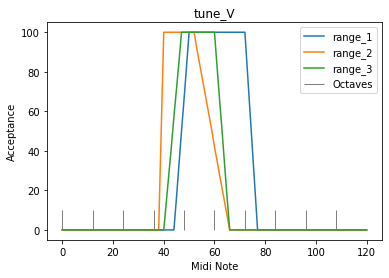

In [447]:
######---  Main  ---######
midi_file_name = gen_midi()

midi_play(midi_file_name)
midi_audio(midi_file_name)
midi_png(midi_file_name)